# Port ANCCR function to Python

Utilizing `calculateANCCR` function in `ANCCR.functions.calculateANCCR.m`.

In [1]:
from typing import Dict, List

import numpy as np

In [24]:
meanITI = 12
numrewards = 500

# anccr model parameters
samplingperiod = 0.2
alpha_anccr = {}
alpha_anccr["exponent"] = 0.1
alpha_anccr["init"] = 0.25
alpha_anccr["min"] = 0.02
alpha_r = 0.2
w = 0.5          
k = 1
minimumrate = 10 ** -3
maximumjitter = 0.1
beta = np.array([[1]])  # Check what beta does in calculate_anccr
threshold = 0.6
T = meanITI*10  # have very large T

nIter = 100
rwrsp = np.zeros((numrewards,nIter))

In [3]:
def legacy_simulate_background_reward(numrewards, rewITI, rewlabel, rewmag, truncation):
    """
    Output an eventlog with exclusively background
    rewards. Inputs may be scalar or arrays depending on the number of unique
    background rewards specified.
    """
    # Set upper limit on ITI (only used if truncation == 1)
    maxrewITI = 3 * rewITI
    # Initialize empty eventlog
    eventlog = np.zeros((numrewards,3))
    # Keep track of reward indices
    running_idx = 0
    # If multiple unique rewards, loop instance for each type
    for irw in range(1, rewlabel+1):
        # Start simulation time at 0
        running_time = 0
        # For each reward (irw) simulate 'numrewards' timesteps
        for i in range(1, numrewards+1):
            # Generate exp. dist. timestep for current reward instance
            new_ts = round(np.random.exponential(rewITI), 4)
            if truncation:  # If capping ITI at maxITI
                while new_ts > maxrewITI:
                    # Simulate a new ts if maxITI is exceeded
                    new_ts = round(np.random.exponential(rewITI), 4)
            # Update eventlog
            eventlog[running_idx, 0] = rewlabel  # Column 1 = label
            eventlog[running_idx, 1] = new_ts + running_time  # " 2 = ts
            eventlog[running_idx, 2] = rewmag  # " 3 = rew. magnitude
            running_idx = running_idx + 1
            running_time = running_time + new_ts  # Update running time
    
    # Resort eventlog by timestamp
    eventlog = eventlog[eventlog[:, 1].argsort()]
    
    # Once any reward reaches to numrewards, finish the session
    # lasttrial = min(cellfun(@(x) find(eventlog(:,1)==x,1,'last'),num2cell(rewlabel)));
    # eventlog(lasttrial+1:end,:) = [];
    
    return eventlog

In [3]:
def simulate_background_reward(numrewards, rewITI, rewlabel, rewmag, truncation):
    """
    Output an eventlog with exclusively background
    rewards. Inputs may be scalar or arrays depending on the number of unique
    background rewards specified.
    """
    labels = np.array([rewlabel] * numrewards)
    rewards = np.array([rewmag] * numrewards)
    ts = np.random.exponential(rewITI, numrewards).cumsum().round(4)
    eventlog = np.array([labels, ts, rewards]).T
    
    return eventlog

In [172]:
def test_simulate_background_reward():
    expected = np.array([
        [1] * 10,
        [
            2.4589,
            3.6462,
            28.4103,
            29.4976,
            34.9972,
            62.9270,
            78.2671,
            85.5094,
            86.0305,
            86.4594,
        ],
        [1] * 10]
    ).T
    actual = simulate_background_reward(10, 12, 1, 1, 0)
    
    assert expected.shape == actual.shape, f"{actual.shape} is not {expected.shape}"
    
test_simulate_background_reward()

In [26]:
eventlog = simulate_background_reward(5, 12, 1, 1, 0)
eventlog

array([[ 1.    , 11.5582,  1.    ],
       [ 1.    , 16.7556,  1.    ],
       [ 1.    , 18.9783,  1.    ],
       [ 1.    , 66.3612,  1.    ],
       [ 1.    , 69.8004,  1.    ]])

In [27]:
eventlog[:,1] += 1
eventlog

array([[ 1.    , 12.5582,  1.    ],
       [ 1.    , 17.7556,  1.    ],
       [ 1.    , 19.9783,  1.    ],
       [ 1.    , 67.3612,  1.    ],
       [ 1.    , 70.8004,  1.    ]])

# Bing Chat attempt at porting calculate_anccr

This code performs several checks on the input arguments and sets default values if they are not provided or are not valid. It also processes the input data in the variable eventlog to handle cases where more than one event happens at the same time. The code then calculates several variables such as ntime, nstimuli, samplingtime, and gamma based on the input data and arguments.

Note that this is just an example of how the provided MATLAB code could be translated into Python. The actual implementation may vary depending on the specific details of the function and its intended behavior.

In [19]:
def calculate_anccr(
    eventlog: np.array,
    T: int,
    alpha: dict,
    k: int,
    samplinginterval: float,
    w: float,
    threshold: float,
    minimumrate: float,
    beta: np.array,
    alpha_r: float,
    maximumjitter: float,
    optolog=None,
    omidx=[np.nan, np.nan],
    exact_mean_or_not=0,
    nevent_for_edge=0
) -> np.array:
    
    if alpha_r > 1:
        alpha_r = 1

    if optolog is None or np.isnan(optolog).any():
        optolog = np.zeros((eventlog.shape[0], 2))

    if omidx is None or np.isnan(omidx).any():
        # First entry is omission index, second entry is corresponding reward index
        # omidx = [np.nan, np.nan]
        omidx = np.array([[np.nan], [np.nan]])

    # if exact_mean_or_not=1, calculate exact mean for Mij instead of using alpha
    exact_mean_or_not = exact_mean_or_not

    # if nevent_for_edge>0, use averaged NC for last nevent to calculate edge
    nevent_for_edge = nevent_for_edge

    # omtrue: whether the omission state will be used or not in the calculation of ANCCR
    omtrue = np.zeros((len(omidx),), dtype=bool)
    
    uniquetime = np.unique(eventlog[:, 1])

    # if more than one event happens at the same time, assume random perceptual delay between them
    for jt in range(len(uniquetime)):
        if sum(eventlog[:, 1] == uniquetime[jt]) == 1:
            continue
        idx = np.where(eventlog[:, 1] == uniquetime[jt])[0]
        eventlog[idx[1:], 1] += np.random.randn(len(idx) - 1) * maximumjitter

    eventlog = eventlog[eventlog[:, 1].argsort()]
    
    ntime = eventlog.shape[0]
    
    nstimuli = len(np.unique(eventlog[:, 0]))
    
    samplingtime = np.arange(0, eventlog[-1, 1], samplinginterval)
    
    # if T is a vector, use T(jt) for the calculation at time jt. otherwise, use fixed T
    if isinstance(T, (int, float)):
        T = np.full((eventlog.shape[0],), T)
    
    gamma = np.exp(-1 / T)
    
    # Initialize model values
    Eij = np.zeros((nstimuli, ntime))
    Ei = np.zeros((nstimuli, ntime+1))
    Mi = np.zeros((nstimuli, ntime+1))
    Delta = np.zeros((nstimuli, ntime))
    
    Mij = np.zeros((nstimuli, nstimuli, ntime))
    PRC = np.zeros((nstimuli, nstimuli, ntime))
    SRC = np.zeros((nstimuli, nstimuli, ntime))
    NC = np.zeros((nstimuli, nstimuli, ntime))
    ANCCR = np.zeros((nstimuli, nstimuli, ntime))
    Rs = np.zeros((nstimuli, nstimuli, ntime))
    
    R = np.zeros((nstimuli, nstimuli))
    
    numevents = np.zeros((nstimuli,))
    
    DA = np.zeros((ntime,))
    
    beta = beta[np.unique(eventlog[:, 0]).astype(int)[0] - 1]
    
    Imct = beta > threshold
    
    nextt = 0
    numsampling = 0
    
    for jt in range(ntime):
        skip = False
        je = int(eventlog[jt, 0]) - 1

        if je in omidx[0]:
            if not omtrue[omidx[0] == je]:
                Delta[:, jt] = Delta[:, jt - 1]
                Eij[:, jt] = Eij[:, jt - 1]
                Mij[:, :, jt] = Mij[:, :, jt - 1]
                PRC[:, :, jt] = PRC[:, :, jt - 1]
                SRC[:, :, jt] = SRC[:, :, jt - 1]
                NC[:, :, jt] = NC[:, :, jt - 1]
                skip = True
                
        if not skip:
            numevents[je] += 1
            if exact_mean_or_not == 0:
                if not isinstance(alpha, dict):
                    alphat = alpha
                else:
                    # if alpha is structure, alpha exponentially decreases from alpha.init to alpha.min w/ alpha.exponent decrease constant
                    alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
            else:
                alphat = 1 / numevents[je]

            if jt > 0:
                # update delta w/prev value
                Delta[:, jt] = Delta[:, jt - 1] * gamma[jt] ** (eventlog[jt, 1] - eventlog[jt - 1, 1])
                # update instantaneous elig. trace w/prev value
                Eij[:, jt] = Eij[:, jt - 1] * gamma[jt] ** (eventlog[jt, 1] - eventlog[jt - 1, 1])
                # update average elig. trace w/prev value
                Mij[:, :, jt] = Mij[:, :, jt - 1]
                # update anccr w/prev value
                ANCCR[~np.isin(np.arange(nstimuli), je), :, jt] = ANCCR[~np.isin(np.arange(nstimuli), je), :, jt - 1]

            # Indicator for whether event has recently happened
            # Delta resets to one at every instance of event w/o cumulative sum
            Delta[je, jt] = 1
            # Increment inst. elig. trace by 1 for event that occurred
            Eij[je, jt] += 1
            # Update avg. elig. trace
            Mij[:, je, jt] += alphat * (Eij[:, jt] - Mij[:, je, jt]) * Imct[je]

            # Subtract baseline elig. from avg. elig. to find successor rep.
            PRC[:, :, jt] = Mij[:, :, jt] - np.tile(Mi[:, jt], (nstimuli, 1)).T
            # Calculate predecessor rep from successor rep.
            SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T
            # Zero out values that may approach -Inf
            belowminrate = Mi[:, jt] / T[jt] < minimumrate
            SRC[belowminrate, :, jt] = 0
            
            # something to make sure only calculating contingency and R after experiencing first outcome
            PRC[numevents == 0, :, jt] = 0
            PRC[:, numevents == 0, jt] = 0
            SRC[numevents == 0, :, jt] = 0
            SRC[:, numevents == 0, jt] = 0
            R[:, numevents == 0] = 0
            R[numevents == 0, :] = 0

            # Calculate net contingency, weighted sum of SRC/PRC
            NC[:, :, jt] = w * SRC[:, :, jt] + (1 - w) * PRC[:, :, jt]

            # Indicator for whether an event is associated with another event
            Iedge = np.mean(NC[:, je, max([0, jt - nevent_for_edge]):jt+1], axis=1) > threshold
            Iedge[je] = False

            # once the cause of reward state is revealed, omission state of that reward state can be used for calculation of ANCCR. Before that, omission state is ignored
            if je in omidx[1] and np.sum(Iedge) > 0:
                omtrue[omidx[1] == je] |= True

            # calculate ANCCR for every event
            # Rjj is externally driven; the magnitude of stimulus an animal just experienced
            R[je, je] = eventlog[jt, 2]

            for ke in range(nstimuli):
                # Update edge indicator
                Iedge_ke = np.mean(NC[:, ke, max([0, jt - nevent_for_edge]):jt+1], axis=1) > threshold
                Iedge_ke[ke] = False
                # update ANCCR
                ANCCR[ke, :, jt] = NC[ke, :, jt] * R[ke, :] - np.sum(ANCCR[:, :, jt] * Delta[:, jt].reshape(-1,1) * np.tile(Iedge_ke.reshape(-1,1), (1,nstimuli)), axis=0)

            if not (optolog[jt, 0] == 1): # If target is not inhibited, normal DA
                DA[jt] = np.sum(ANCCR[je,:,jt]*Imct)
            else: # If target is inhibited, replace DA
                DA[jt] = optolog[jt,1]

            if je in omidx[0]:
                je_om = np.where(je == omidx[0])[0]
                # if the current state is omission of j, R(omission,j) = R(j,j)
                R[je, omidx[je_om, 1]] = R[omidx[je_om, 1], omidx[je_om, 1]]
                # omission state is an MCT
                Imct[je] = True

            # This must come after opto s.t. Imct is not formed before opto applied
            Imct[je] |= DA[jt] + beta[je] > threshold

            # Update estimated reward value
            Rs[:, :, jt] = R
            if DA[jt] >= 0:
                # For positive DA response, use standard update rule
                R[:, je] += alpha_r * (eventlog[jt, 2] - R[:, je])
            else:
                # For negative DA response, use overprediction update rule
                if np.any(Iedge):
                    R[Iedge, je] -= alpha_r * R[Iedge, je] * ((Delta[Iedge, jt] / numevents[Iedge]) / np.sum((Delta[Iedge, jt] / numevents[Iedge])))
                else:
                    R[:, je] = R[:, je]
        
        # Update sample eligibility trace (Mi-)
        if jt < ntime:
            # Time to sample baseline b/t events
            if jt + 1 < len(eventlog):
                subsamplingtime = samplingtime[(samplingtime >= eventlog[jt, 1]) & (samplingtime < eventlog[jt+1, 1])]
            else:
                subsamplingtime = samplingtime[(samplingtime >= eventlog[jt, 1])]

            Ei[:, jt+1] = Ei[:, jt] * gamma[jt] ** samplinginterval
            if subsamplingtime.size > 0:
                for jjt in range(nextt, jt + 1):
                    if eventlog[jjt, 0] in omidx[0]:
                        if not omtrue[omidx[0] == eventlog[jjt, 0]]:
                            continue
                    Ei[int(eventlog[jjt, 0]) - 1, jt+1] += gamma[jt] ** (subsamplingtime[0] - eventlog[jjt, 1])
                nextt = jt + 1

            # update alpha of sample eligibility trace
            if exact_mean_or_not == 0:
                if not isinstance(alpha, dict):
                    alphat = alpha
                else:
                    alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
            else:
                alphat = 1 / (numsampling + 1)

            # Update avg. sample eligibility trace
            Mi[:, jt+1] = Mi[:, jt] + k * alphat * (Ei[:, jt+1] - Mi[:, jt])
            for iit in range(1, len(subsamplingtime)):
                iit += 1
                if exact_mean_or_not == 0:
                    if not isinstance(alpha, dict):
                        alphat = alpha
                    else:
                        alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
                else:
                    alphat = 1 / (numsampling + iit)

                Ei[:, jt+1] *= gamma[jt] ** samplinginterval
                Mi[:, jt+1] += k * alphat * (Ei[:, jt+1] - Mi[:, jt+1])
            numsampling += len(subsamplingtime)
            
    return DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi
    

In [176]:
eventlog = simulate_background_reward(numrewards, meanITI, 0, 1, 0)
eventlog[:,1] += 1

In [178]:
eventlog[:10,]

array([[  0.    ,   5.6342,   1.    ],
       [  0.    ,   7.9512,   1.    ],
       [  0.    ,  21.851 ,   1.    ],
       [  0.    ,  34.2218,   1.    ],
       [  0.    ,  58.0736,   1.    ],
       [  0.    ,  80.165 ,   1.    ],
       [  0.    ,  93.8553,   1.    ],
       [  0.    ,  97.0394,   1.    ],
       [  0.    ,  98.9482,   1.    ],
       [  0.    , 108.671 ,   1.    ]])

In [51]:
meanITI = 12
numrewards = 8  # 500

# anccr model parameters
samplingperiod = 0.2
alpha_anccr = {}
alpha_anccr["exponent"] = 0.1
alpha_anccr["init"] = 0.25
alpha_anccr["min"] = 0.02
alpha_r = 0.2
w = 0.5          
k = 1
minimumrate = 10 ** -3
maximumjitter = 0.1
beta = np.array([[1]])  # Check what beta does in calculate_anccr
threshold = 0.6
T = meanITI*10  # have very large T

nIter = 100
rwrsp = np.zeros((numrewards,nIter))

In [52]:
eventlog = np.array([
    [1.0, 2.4589, 1.0],
    [1.0, 3.6462, 1.0],
    [1, 28.4103, 1.0],
    [1, 29.4976, 1.0],
    [1, 34.9972, 1.0],
    [1, 62.9270, 1.0],
    [1, 78.2671, 1.0],
    [1, 85.5094, 1.0],
])
eventlog

array([[ 1.    ,  2.4589,  1.    ],
       [ 1.    ,  3.6462,  1.    ],
       [ 1.    , 28.4103,  1.    ],
       [ 1.    , 29.4976,  1.    ],
       [ 1.    , 34.9972,  1.    ],
       [ 1.    , 62.927 ,  1.    ],
       [ 1.    , 78.2671,  1.    ],
       [ 1.    , 85.5094,  1.    ]])

In [53]:
DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi = calculate_anccr(eventlog, T, alpha_anccr, k, samplingperiod, w, threshold,
                   minimumrate, beta, alpha_r, maximumjitter)

/tmp/ipykernel_26/1831270426.py:134: RuntimeWarning: invalid value encountered in true_divide
  SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T


In [55]:
DA.round(4)

array([ 0.1141, -0.1882, -0.649 , -0.8294, -1.5455, -1.2542, -1.3596,
       -1.7033])

In [27]:
# simulation
for iiter in range(nIter):
    if iiter % 10 == 0: print(iiter)
    eventlog = simulate_background_reward(numrewards, meanITI, 1, 1, 0)
    eventlog[:,1] += 1
    
    DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi = calculate_anccr(eventlog, T, alpha_anccr, k, samplingperiod, w, threshold,
                   minimumrate, beta, alpha_r, maximumjitter)
    eventtimeline = eventlog[0:numrewards,0]
    
    rwrsp[:,iiter] = DA


0


/tmp/ipykernel_26/1831270426.py:134: RuntimeWarning: invalid value encountered in true_divide
  SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T


10
20
30
40
50
60
70
80
90


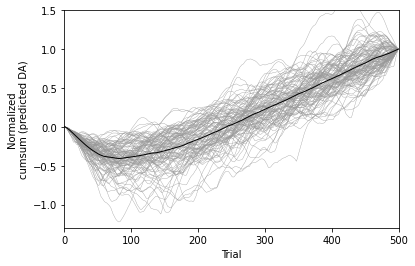

In [28]:
# FigS8J
import matplotlib.pyplot as plt

fHandle = plt.figure()

plt.plot(
    np.cumsum(rwrsp,axis=0) / np.tile(np.sum(rwrsp,axis=0), (numrewards,1)),
    color=[0.6,0.6,0.6],
    linewidth=0.35
)
plt.plot(np.mean(np.cumsum(rwrsp,axis=0)/np.tile(np.sum(rwrsp,axis=0),(numrewards,1)),axis=1),
         color='k',
         linewidth=1
)
plt.ylim([-1.3, 1.5])
plt.xlim([0, numrewards])
plt.xlabel('Trial')
plt.ylabel('Normalized\ncumsum (predicted DA)');
# plt.gca().set(xticklabels=[0,200,400],yticklabels=[-1,0,1])

In [ ]:
DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi

In [29]:
(DA == ANCCR).all()

True

In [30]:
(NC == ANCCR).all()

True

In [46]:
(PRC[:, :, 1:100].round(4) == SRC[:, :, 1:100].round(4)).all()

True